### Data Overview
## Average Weekly Earnings (AWE):
https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/averageweeklyearningsearn01
EARN01: Average weekly earnings (ONS) - October 2025
[Weekly Earnings (KAB9)] of the [Whole Economy]
Observations set to start: January 2000

### CPIH Index (CPIH):
https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l522/mm23
CPIH INDEX 00: ALL ITEMS 2015=100 (ONS) - October 2025
Base year is 2015 (2015=100)
Obsevations set to start: 2000 JAN

### Productivity:
https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/labourproductivity/datasets/labourproductivity
Labour Productivity Time Series (ONS) - August 2025
[UK Whole Economy: Output per hour worked SA: Index 2022 = 100] -- this is the column we extract from the dataset since it is in index form
 Observations set to start: Q1 2000

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
xls = pd.ExcelFile("data/raw/awe.xls")
print(xls.sheet_names)

#Skip the first 8 rows which contain title and text
awe = pd.read_excel("data/raw/awe.xls", sheet_name = "1. AWE Total Pay", skiprows=9, header=None)
#Skip the first 8 rows which contain title and text
cpi = pd.read_csv("data/raw/cpi_index.csv", skiprows=8, header=None)
prod = pd.read_excel("data/raw/prdy.xlsx")

# Filtering columns of Average Weekly Earnings -- the dataset starts from January 2000
awe = awe[[0,1]]
awe.columns = ['Date', 'AWE']

#Drops rows where Weekly Earnings column is empty -- used for some empty text cells
awe.dropna(subset=['AWE'], inplace=True)

# Filtering columns of CPIH dataset -- starting from January 2000
cpi = cpi[[0,1]]
cpi.columns = ['Date', 'CPIH']

start_idx = cpi.loc[cpi['Date'].str.startswith('2000 JAN')].index[0]
cpi = cpi.loc[start_idx:].reset_index(drop=True)


# Filtering columns of productivity dataset - starting from Q1 of 2000
prod = prod[['Title', 'UK Whole Economy: Output per hour worked SA: Index 2022 = 100']]
prod = prod.rename(columns={'Title': 'Date',
                            'UK Whole Economy: Output per hour worked SA: Index 2022 = 100': 'OutputHR'})

start_idx = prod.loc[prod['Date'].str.startswith('2000 Q1')].index[0]
prod = prod.loc[start_idx:].reset_index(drop=True)

['Introduction', '1. AWE Total Pay', '2. AWE Bonus Pay', '3. AWE Regular Pay', '4. AWE Total Pay Index', '5. AWE Regular Pay Index', '6. Real AWE', 'Sampling Variability']


C:\Users\andre\PycharmProjects\uk_inflation_wage_project\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [24]:
# We expect 1-to-1 for awe and cpi, call shape to confirm
print(cpi.shape)
print(awe.shape)

# We call tail to see why there is one extra observation -- CPI has a September observation
print(cpi.tail())
print(awe.tail())

# Dropping last observation
cpi = cpi[0:-1]

# Converting both datasets to datetime
cpi['Date'] = pd.to_datetime(cpi['Date'], format = '%Y %b')
awe['Date'] = pd.to_datetime(awe['Date'])

# Converting columns to Month objects
cpi['Month'] = cpi['Date'].dt.to_period('M')
awe['Month'] = awe['Date'].dt.to_period('M')

# Merging on month
ts = pd.merge(cpi, awe, how='inner', on=['Month'])

# Dropping unused date columns and setting index to Month
ts.drop(columns=['Date_x', 'Date_y'], inplace=True)
ts.set_index('Month', inplace=True)

ts.head()


(309, 2)
(308, 2)
         Date   CPIH
304  2025 MAY  138.0
305  2025 JUN  138.4
306  2025 JUL  138.5
307  2025 AUG  138.9
308  2025 SEP  138.9
                    Date         AWE
303  2025-04-01 00:00:00  719.763788
304  2025-05-01 00:00:00  722.569363
305  2025-06-01 00:00:00  724.738409
306  2025-07-01 00:00:00  728.291840
307  2025-08-01 00:00:00  732.815546


,CPIH,AWE
Month,,
2000-01,72.6,304.722925
2000-02,72.8,299.818577
2000-03,73.0,311.418715
2000-04,73.3,308.748756
2000-05,73.5,311.178774


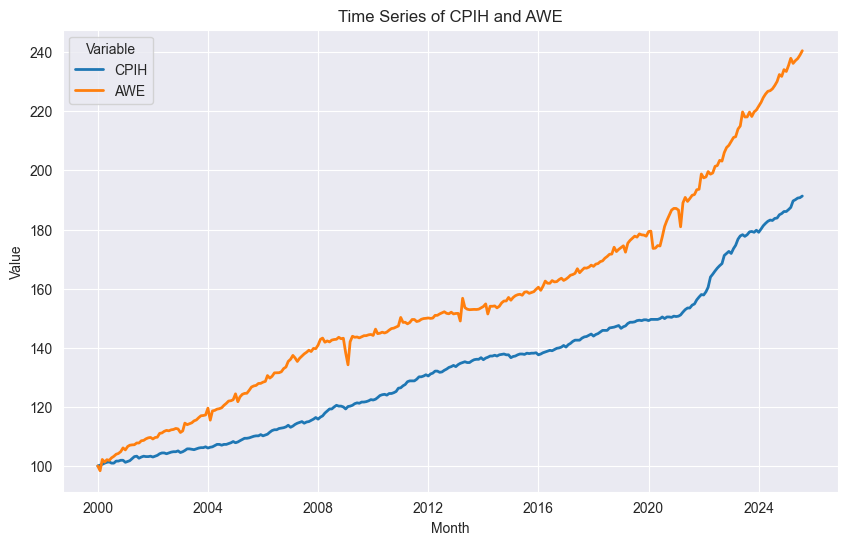

In [25]:
# Melting data for seaborn
ts_plot = ts.copy()
ts_plot = ts_plot.reset_index()
ts_plot.head()
ts_plot = ts_plot.melt(id_vars=['Month'], value_vars=['CPIH', 'AWE'], var_name='Variable', value_name='Value')

# Normalizing to show trends
ts_plot['Value_norm'] = ts_plot.groupby('Variable')['Value'].transform(lambda x: x / x.iloc[0] * 100)

# Formatting issues - need to convert to datetime
ts_plot['Month'] = ts_plot['Month'].dt.to_timestamp()

# Setting up plots
plt.figure(figsize=(10,6))
sns.lineplot(
    data=ts_plot,
    x='Month',
    y='Value_norm',
    hue='Variable',
    linewidth=2
)
plt.title('Time Series of CPIH and AWE')
plt.xlabel('Month')
plt.ylabel('Value')
plt.show()

In [26]:
# Transforming Quarter strings for PeriodIndex to recognize
prod['Date'] = prod['Date'].apply(lambda x: x.replace(' ', ''))
prod['Quarter'] = pd.PeriodIndex(prod['Date'], freq='Q')

# Creating a copy of the merged dataframe
ts_prod = ts.copy()
# Converting index to timestamp
ts_prod.index = ts_prod.index.to_timestamp(how='start')

# Converting to timestamp
prod['Date_q'] = prod['Quarter'].dt.to_timestamp()

# Setting index and resampling
prod.set_index('Date_q', inplace=True)
prod_monthly = prod.resample('MS').ffill()

# Dropping unused columns
prod_monthly.drop(['Date', 'Quarter'], axis=1, inplace=True)

# Reindexing on merged dataset's index, using forward-fill to fill values outside of data interval
prod_monthly_realign = prod_monthly.reindex(ts_prod.index, method='ffill')

# Adding reindexed column to ts_prod as 'Productivity'
ts_prod['Productivity'] = prod_monthly_realign['OutputHR']

#Missing first row so fill in
ts_prod.at[ts_prod.index[0], 'Productivity'] = ts_prod['Productivity'].iloc[1]

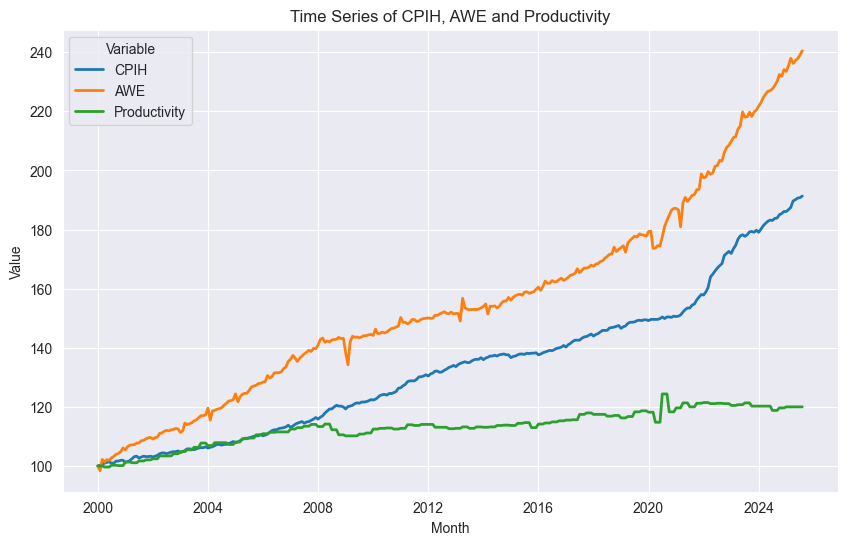

In [27]:
# Melting data for seaborn
ts_plot_prod = ts_prod.copy()
ts_plot_prod = ts_plot_prod.reset_index()
ts_plot_prod = ts_plot_prod.melt(id_vars=['Month'], value_vars=['CPIH', 'AWE', 'Productivity'], var_name='Variable', value_name='Value')

# Normalizing to show trends
ts_plot_prod['Value_norm'] = ts_plot_prod.groupby('Variable')['Value'].transform(lambda x: x / x.iloc[0] * 100)

# Setting up plots
plt.figure(figsize=(10,6))
sns.lineplot(
    data=ts_plot_prod,
    x='Month',
    y='Value_norm',
    hue='Variable',
    linewidth=2
)
plt.title('Time Series of CPIH, AWE and Productivity')
plt.xlabel('Month')
plt.ylabel('Value')
plt.show()

# Line Plot Interpretation
From the plot we can see that productivity and weekly earnings followed the same trajectory, until productivity decouples from 2008 and onwards. It is then very flat with a dip and spike in 2020-2021. These two movements represent the 2008 recession and the COVID recession respectively.

<Figure size 1000x600 with 0 Axes>

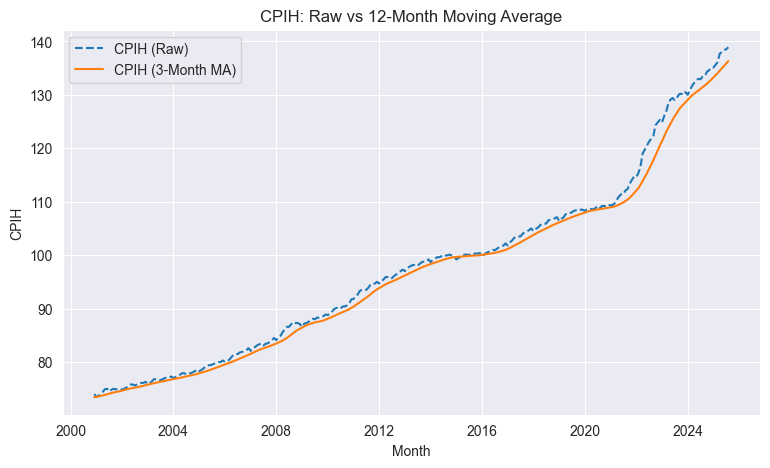

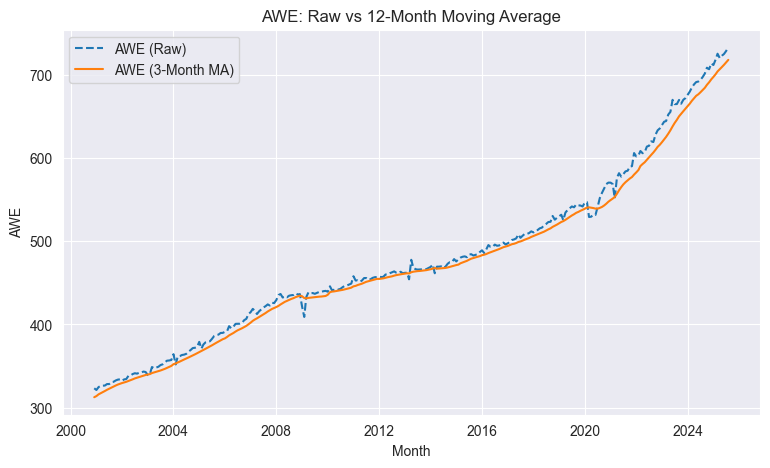

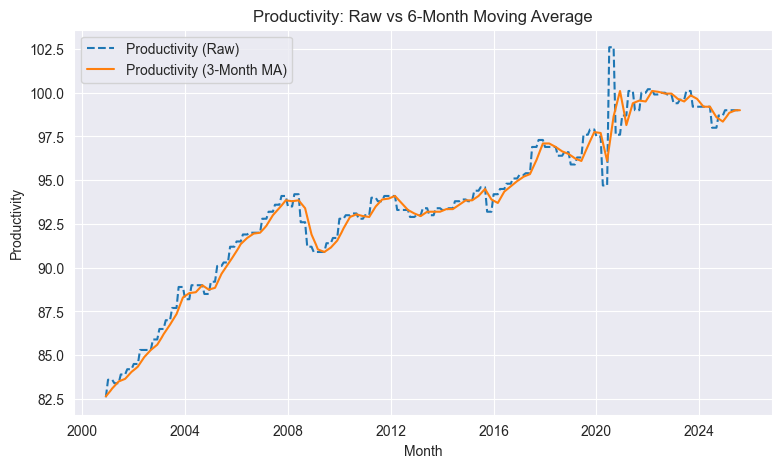

In [28]:
# Creating a copy of combined dataframe
ts_ma = ts_prod.copy()
# Calculating moving averages
ts_ma['CPIH_ma'] = ts_ma['CPIH'].rolling(window=12).mean()
ts_ma['AWE_ma'] = ts_ma['AWE'].rolling(window=12).mean()
ts_ma['Prod_ma'] = ts_ma['Productivity'].rolling(window=6).mean()

# Dropping empty values
ts_ma.dropna(inplace=True)
plt.figure(figsize=(10,6))

# Plotting raw data and MA for each variable
var_list = [('CPIH', 'CPIH_ma'), ('AWE', 'AWE_ma'), ('Productivity', 'Prod_ma')]
for var, ma in var_list:
    plt.figure(figsize=(9, 5))
    sns.lineplot(data=ts_ma, x='Month', y=var, label=f'{var} (Raw)', linestyle='--')
    sns.lineplot(data=ts_ma, x='Month', y=ma, label=f'{var} (3-Month MA)')
    if var=='Productivity':
        plt.title(f'{var}: Raw vs 6-Month Moving Average')
    else:
        plt.title(f'{var}: Raw vs 12-Month Moving Average')
    plt.xlabel('Month')
    plt.ylabel(var)
    plt.legend()
    plt.show()


# Moving Average Interpretation
The moving average curves were computed at 12 month windows for CPIH and AWE since they are observed monthly. The productivity parameter was computed at a 6 month window since it is observed quarterly and a 12-month window would produce an overly smooth line without much information being communicated.

### CPIH curve:
Clear positive long-term growth but the momentum (gap between the two curves) rapidly increases after 2021. Oil price collapse and monetary policy in the period between 2015-2017 represent a relative flattening of the MA curve, inflation hovered around 0-1%.

### AWE curve:
Positive long-term growth with instances where the raw data dips below the MA, slowing growth in the case of the 2008 Crisis and the Covid crisis. The Covid dip is more acute. These represent temporary shocks to the AWE variable. After the pandemic the curve mirrors the CPIH curve as the momentum picks up and the distance between the two curves increases

### Productivity:
Positive long-term growth with many temporary shocks. Large dip during the 2008 Crisis and dip then massive spike during the Covid pandemic. The gradual dip then slow recovery of 2008 can be explained by the nature of the crisis, the shock resulted in structural and cyclical unemployment. The shock was endogenously determined and follows a smooth U-shape. The pandemic was an exogenous shock to the entire world economy, the unemployment was sudden and caused a huge dip in productivity. Although some jobs were lost to frictional unemployment, most workers were facing temporary unemployment due to the government's lockdown policies. Once restrictions were eased the massive influx of workers returning to work caused an upward spike in productivity.


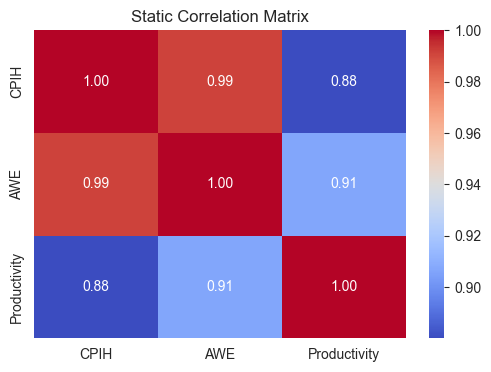

In [29]:
# Correlation matrix
corr_matrix = ts_prod[['CPIH', 'AWE', 'Productivity']].corr()

# Heatmap on corr_matrix
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Static Correlation Matrix')
plt.show()

# Static Correlation Interpretation
All three variable are highly correlated with AWE and CPIH exhibiting an almost perfect positive correlation. The smallest coefficient is the one between CPIH and Productivity, while still being sizeable. All their signs are positive meaning that they all move in the same direction.

This is intuitive as in the long-run we expect all three variables to grow and since each variable is co-determined by the others we expect their long-run rate of growth to be almost identical. This tell us nothing about their behaviours during certain periods e.g. economic downturns, exogenous shocks. Rolling correlation coefficients will be used to answer this.

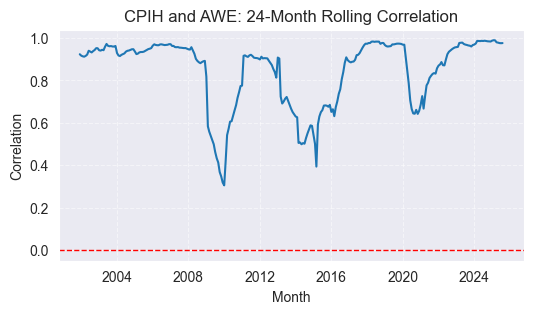

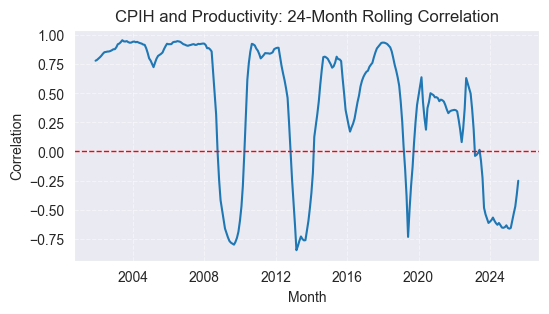

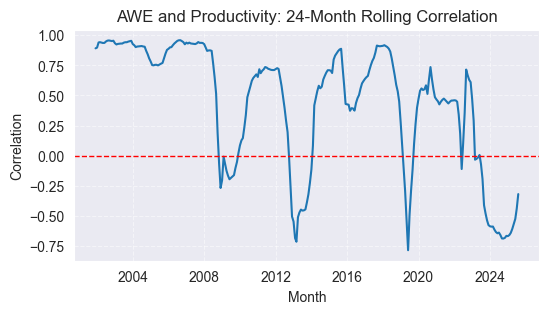

In [30]:
# Rolling correlations between variables
ts_prod_cor = pd.DataFrame()
ts_prod_cor['CPIH_AWE_corr'] = ts_prod['CPIH'].rolling(24).corr(ts_prod['AWE'])
ts_prod_cor['CPIH_Prod_corr'] = ts_prod['CPIH'].rolling(24).corr(ts_prod['Productivity'])
ts_prod_cor['AWE_Prod_corr']  = ts_prod['AWE'].rolling(24).corr(ts_prod['Productivity'])

# List of columns and graph labels
corr_list = [('CPIH_AWE_corr', 'CPIH and AWE'),
             ('CPIH_Prod_corr', 'CPIH and Productivity'),
             ('AWE_Prod_corr', 'AWE and Productivity')]

# Looping over columns and graph labels to produce 3 plots
for corr, label in corr_list:
    plt.figure(figsize=(6,3))
    sns.lineplot(data=ts_prod_cor[corr])
    plt.title(f'{label}: 24-Month Rolling Correlation')
    plt.xlabel('Month')
    plt.ylabel('Correlation')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.show()


# Rolling Correlation Interpretation
### CPIH and AWE:
Inflation and Earnings are seen to be highly correlated but get closest to decoupling in several time periods signifiying crises. Of particular interest is that during the pandemic the correlation coefficient falls but not to the same degree as the 2008 crisis or even the low inflationary period (high interest period) during the 2010s. Their correlation coefficient never dips below 0 meaning they move together even when they are not correlated

### CPIH and Productivity:
Inflation and Productivity are also strongly correlated during the entire duration. What changes is the sign of the correlation coefficient: during crises they move together but in opposite directions. This is expected as inflation is assumed to spike in crises while productivity dips. There is a dip during 2016 where they exhibit low correlation and after the pandemic the correlation coefficient shrinks, in both directions.

### AWE and Productivity:
Strong correlation and then decoupling after the 2008 crisis, with a sign change. AWE and Productivity during this time period are moving in opposite directions but are not significantly correlated. In subsequent periods they exhibit strong correlation with sign changes, most notably during the pandemic. In the raw data graph this is represented by the AWE curve remaining relatively stable and growing (due to transfer payments to the unemployed) while productivity dipping. We can see that the two variables only really decouple during the 2008 crisis, averaging strong to moderate correlation in either direction



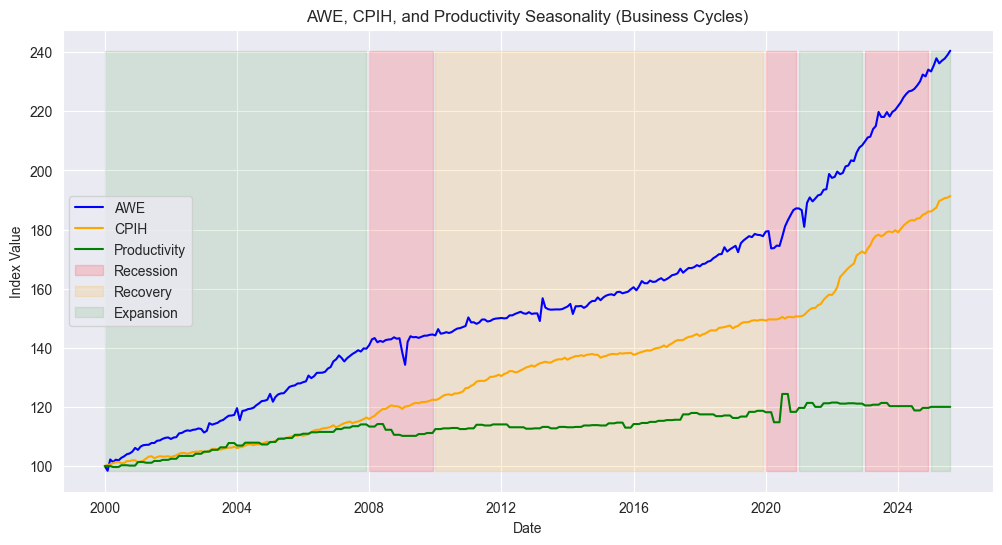

In [32]:
# Seasonal Plots
# 2000-2007 Expansion
# 2008-2009 Recession
# 2010-2019 Recovery
# 2020 Recession
# 2021-2022 Expansion
# 2023-2024 Recession
# 2025 Expansion
ts_season = ts_prod.copy()

# Expansion dummy column is 1 if between expansion year range
ts_season['Expansion'] = ((ts_season.index.year.isin(range(2000,2008)) |
                           (ts_season.index.year.isin([2021, 2022])) |
                            (ts_season.index.year.isin([2025])))).astype(int)

# Recession dummy column is 1 if between expansion year range
ts_season['Recession'] = ((ts_season.index.year.isin([2008, 2009])) |
                        (ts_season.index.year.isin([2020])) |
                        (ts_season.index.year.isin([2023, 2024]))).astype(int)

# Recovery dummy column is 1 if between expansion year range
ts_season['Recovery'] = (ts_season.index.year.isin(range(2010,2020))).astype(int)

# Creating column list to loop over
col_list = [('CPIH','CPIH_norm'), ('AWE','AWE_norm'), ('Productivity', 'PROD_norm')]

# Creating a copy of the data frame
ts_season_norm = ts_season.copy()

# Looping over the column and the label to normalize each column in new df
for col, label in col_list:
    ts_season_norm[label] = ts_season[col].transform(lambda x: x / x.iloc[0] * 100)

plt.figure(figsize=(12,6))

# Plotting each variable
plt.plot(ts_season_norm.index, ts_season_norm['AWE_norm'], label='AWE', color='blue')
plt.plot(ts_season_norm.index, ts_season_norm['CPIH_norm'], label='CPIH', color='orange')
plt.plot(ts_season_norm.index, ts_season_norm['PROD_norm'], label='Productivity', color='green')

# Shading each phase of business cycle
# Recession
plt.fill_between(ts_season_norm.index, ts_season_norm[['AWE_norm','CPIH_norm','PROD_norm']].min().min(),
                 ts_season_norm[['AWE_norm','CPIH_norm','PROD_norm']].max().max(),
                 where=ts_season_norm['Recession']==1, color='red', alpha=0.15, label='Recession')
# Recovery
plt.fill_between(ts_season_norm.index, ts_season_norm[['AWE_norm','CPIH_norm','PROD_norm']].min().min(),
                 ts_season_norm[['AWE_norm','CPIH_norm','PROD_norm']].max().max(),
                 where=ts_season_norm['Recovery']==1, color='orange', alpha=0.15, label='Recovery')
# Expansion
plt.fill_between(ts_season_norm.index, ts_season_norm[['AWE_norm','CPIH_norm','PROD_norm']].min().min(),
                 ts_season_norm[['AWE_norm','CPIH_norm','PROD_norm']].max().max(),
                 where=ts_season_norm['Expansion']==1, color='green', alpha=0.1, label='Expansion')

plt.title('AWE, CPIH, and Productivity Seasonality (Business Cycles)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.show()


### Seasonal Interpretation
## Normalized values - growth rates

# AWE:
During the initial expansion the curve experiences linear growth, it then flattens during the recession. Its growth rate does not reach the expansion level during the recovery. The Covid recession causes an irregular dip and then a rapid increase in the growth rate which continues through both the expansion and mini-recession of 2023-24.

# CPIH:
Stable growth rate through the expansion and recession of 2008-2009. Slight oscillation through the recovery: peaks, falls then reaches new peak. Flat through the COVID recession (monetary policy), then rapid increase in the growth rate through the expansion. Growth rate falls during the mini-recession of 2023-24.

# Productivity
Growth rate is aligned with AWE almost exactly until it decouples in 2008 recession. Relatively flat through the recovery, dips and spikes during Covid then remains flat. Productivity growth is stagnant.

In [33]:
# Saving cleaned and combined dataset
ts_prod.to_csv('data/preprocessed/dataset.csv')